In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
"""
Encode categorical variables and fill missing values with 0
"""
def encode_and_fill(df):
    s = (df.dtypes == 'object')
    object_cols = list(s[s].index)

    ordinal_encoder = OrdinalEncoder()
    label_df = df.copy()
    label_df[object_cols] = ordinal_encoder.fit_transform(df[object_cols])

    label_df = label_df.fillna(0)

    return label_df

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Score: 0.3630962607818937


Text(0, 0.5, 'Predicted site_eui Values')

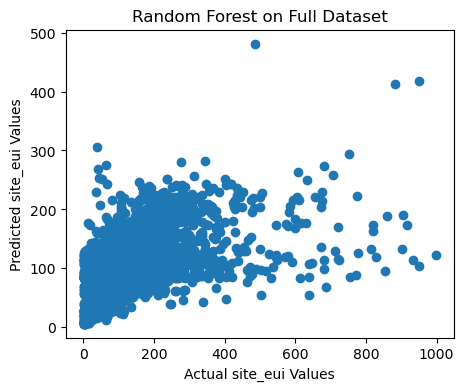

In [3]:
### RANDOM FOREST ON FULL DATA ###

# Get data
train_df = pd.read_csv('train.csv')
train_df = encode_and_fill(train_df)
y = np.array(train_df['site_eui']).reshape(-1,1)
X = train_df.drop(columns=['site_eui', 'id'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Run random forest
rf = RandomForestRegressor(n_estimators=100, max_depth=8)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
print("Score:", score)

# Plot Results
plt.figure(figsize=(5,4))
plt.scatter(y_test,y_pred)
plt.title("Random Forest on Full Dataset")
plt.xlabel("Actual site_eui Values")
plt.ylabel("Predicted site_eui Values")

In [4]:
### SPLIT DATA BASED ON BUILDING TYPE ###

train_df = pd.read_csv('train.csv')

# Separate data for commercial and residential buildings
com_train_df = train_df.loc[train_df['building_class'] == 'Commercial']
res_train_df = train_df.loc[train_df['building_class'] == 'Residential']
com_train_df = com_train_df.drop(columns=['building_class'])
res_train_df = res_train_df.drop(columns=['building_class'])

# Encode and fill
com_train_df = encode_and_fill(com_train_df)
res_train_df = encode_and_fill(res_train_df)

y_com_train = np.array(com_train_df['site_eui']).reshape(-1,1)
X_com_train = com_train_df.drop(columns=['site_eui', 'id'])
y_res_train = np.array(res_train_df['site_eui']).reshape(-1,1)
X_res_train = res_train_df.drop(columns=['site_eui', 'id'])

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Score: 0.4093450495500126


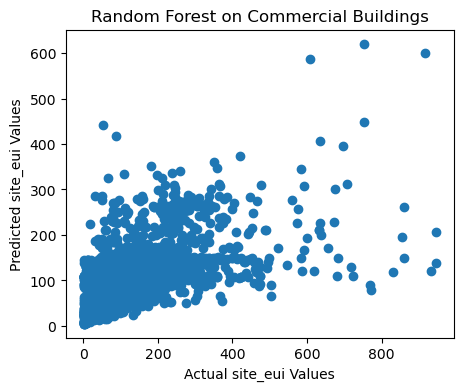

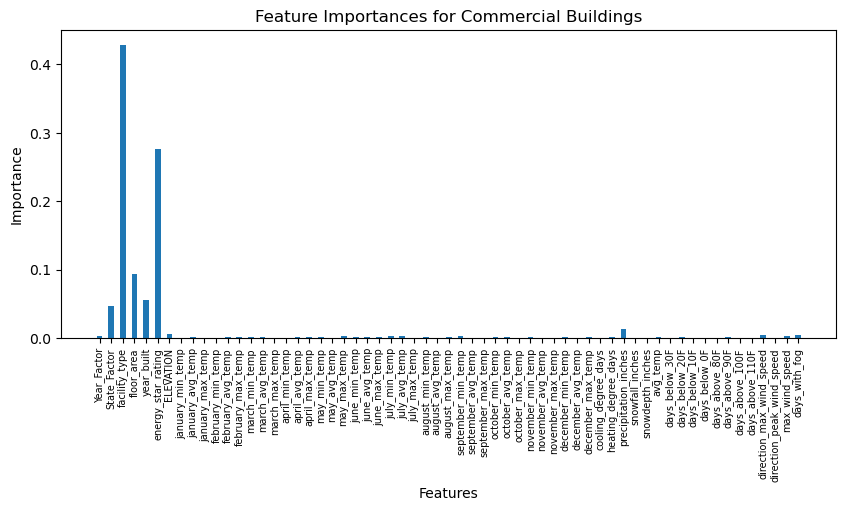

In [5]:
### RANDOM FOREST ON COMMERCIAL BUILDINGS ###
X_train, X_test, y_train, y_test = train_test_split(X_com_train, y_com_train, test_size=0.3)
print(type(X_train))
print(type(y_train))

# Run random forest
rf = RandomForestRegressor(n_estimators=40, max_depth=8)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
print("Score:", score)

# Plot Results
plt.figure(figsize=(5,4))
plt.scatter(y_test,y_pred)
plt.title("Random Forest on Commercial Buildings")
plt.xlabel("Actual site_eui Values")
plt.ylabel("Predicted site_eui Values")
plt.show()

# Plot Feature Importances
plt.figure(figsize=(10,4))
features = np.array(X_com_train.columns)
plt.bar(features, rf.feature_importances_, width=0.5)
plt.xticks(fontsize=7, rotation=90)
plt.title("Feature Importances for Commercial Buildings")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Score: 0.32381600678069766


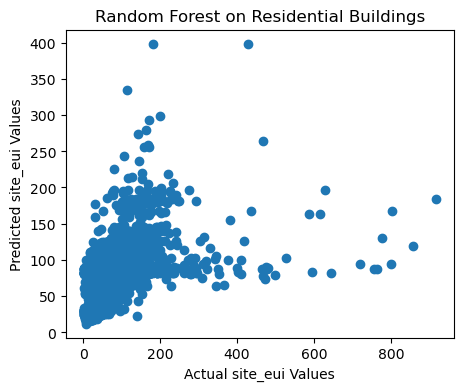

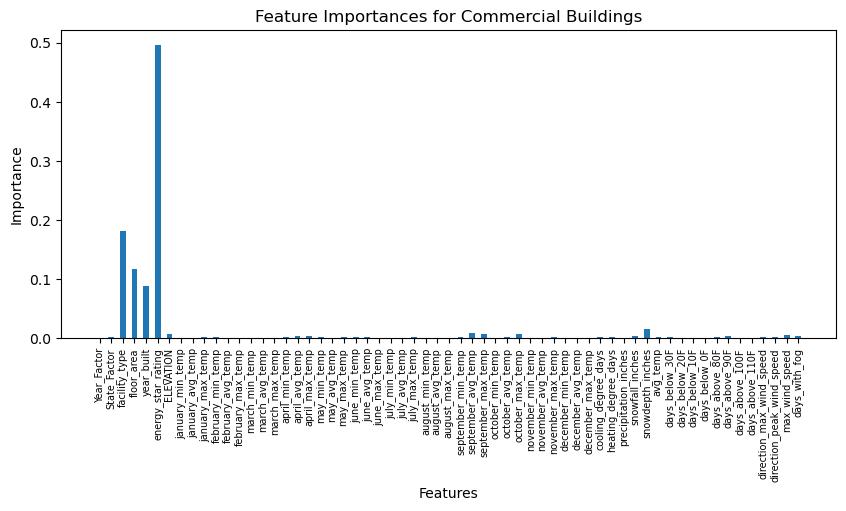

In [6]:
### RANDOM FOREST ON RESIDENTIAL BUILDINGS ###
X_train, X_test, y_train, y_test = train_test_split(X_res_train, y_res_train, test_size=0.3)

# Run random forest
rf = RandomForestRegressor(n_estimators=40, max_depth=8)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
print("Score:", score)

# Plot Results
plt.figure(figsize=(5,4))
plt.scatter(y_test,y_pred)
plt.title("Random Forest on Residential Buildings")
plt.xlabel("Actual site_eui Values")
plt.ylabel("Predicted site_eui Values")

# Plot Feature Importances
plt.figure(figsize=(10,4))
features = np.array(X_com_train.columns)
plt.bar(features, rf.feature_importances_, width=0.5)
plt.xticks(fontsize=7, rotation=90)
plt.title("Feature Importances for Commercial Buildings")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Score: 0.5330800121638513


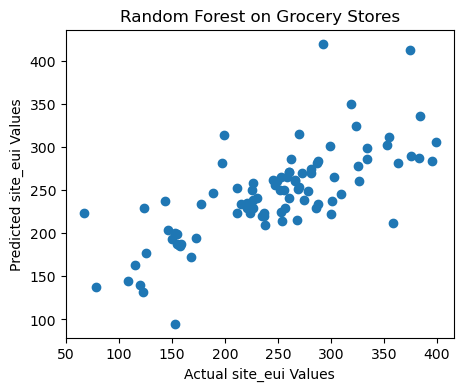

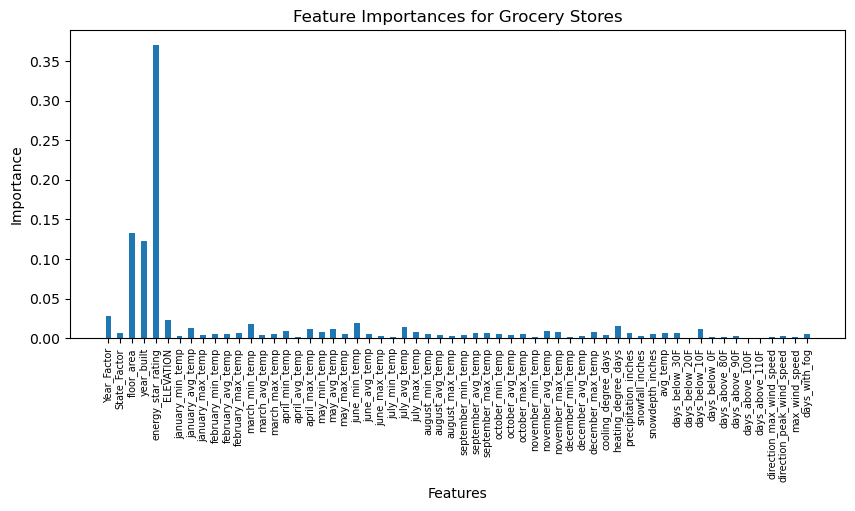

In [7]:
### RANDOM FOREST ON GROCERY STORES (COMMERCIAL) ###

# Separate data for grocery facility type
commercial_df = train_df.loc[train_df['building_class'] == 'Commercial']
commercial_df = commercial_df.drop(columns=['building_class'])
grocery_df = com_train_df.loc[commercial_df['facility_type'] == 'Grocery_store_or_food_market']
grocery_df = grocery_df.drop(columns=['facility_type'])

# Encode and fill
grocery_df = encode_and_fill(grocery_df)

y_grocery = np.array(grocery_df['site_eui']).reshape(-1,1)
X_grocery = grocery_df.drop(columns=['site_eui', 'id'])

X_train, X_test, y_train, y_test = train_test_split(X_grocery, y_grocery, test_size=0.2)

# Run random forest
rf = RandomForestRegressor(n_estimators=40, max_depth=8)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
print("Score:", score)

# Plot Results
plt.figure(figsize=(5,4))
plt.scatter(y_test,y_pred)
plt.title("Random Forest on Grocery Stores")
plt.xlabel("Actual site_eui Values")
plt.ylabel("Predicted site_eui Values")
plt.show()

# Plot Feature Importances
plt.figure(figsize=(10,4))
features = np.array(X_grocery.columns)
plt.bar(features, rf.feature_importances_, width=0.5)
plt.xticks(fontsize=7, rotation=90)
plt.title("Feature Importances for Grocery Stores")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()


/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Score: 0.493436402634716


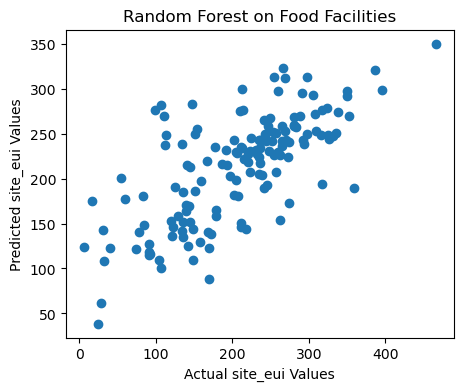

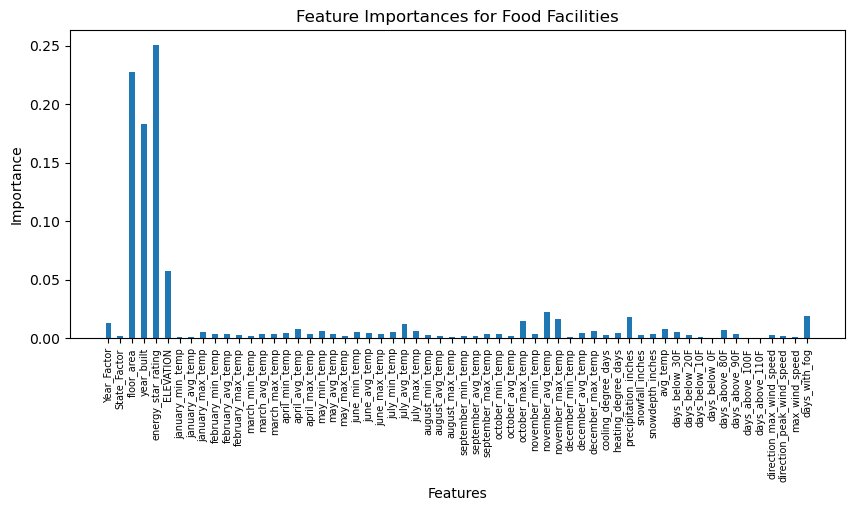

In [8]:
### RANDOM FOREST ON FOOD FACILITIES (COMMERCIAL) ###

# Separate data for grocery facility type
food_facilities = ['Grocery_store_or_food_market','Food_Service_Uncategorized','Food_Service_Other','Food_Service_Restaurant_or_cafeteria', 'Food_Sales']
commercial_df = train_df.loc[train_df['building_class'] == 'Commercial']
commercial_df = commercial_df.drop(columns=['building_class'])
food_df = com_train_df.loc[commercial_df['facility_type'].isin(food_facilities)]
food_df = food_df.drop(columns=['facility_type'])

# Encode and fill
food_df = encode_and_fill(food_df)

y_food = np.array(food_df['site_eui']).reshape(-1,1)
X_food = food_df.drop(columns=['site_eui', 'id'])

X_train, X_test, y_train, y_test = train_test_split(X_food, y_food, test_size=0.24)

# Run random forest
rf = RandomForestRegressor(n_estimators=40, max_depth=8)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
print("Score:", score)

# Plot Results
plt.figure(figsize=(5,4))
plt.scatter(y_test,y_pred)
plt.title("Random Forest on Food Facilities")
plt.xlabel("Actual site_eui Values")
plt.ylabel("Predicted site_eui Values")
plt.show()

# Plot Feature Importances
plt.figure(figsize=(10,4))
features = np.array(X_food.columns)
plt.bar(features, rf.feature_importances_, width=0.5)
plt.xticks(fontsize=7, rotation=90)
plt.title("Feature Importances for Food Facilities")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()
